## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Висков Василий

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

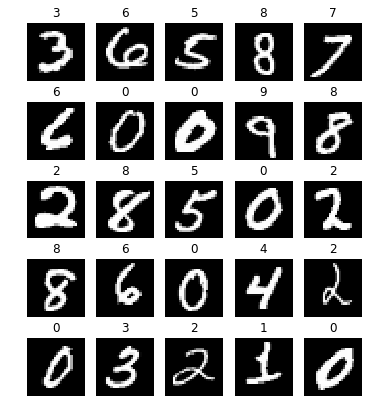

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)
    
def he_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / weight.size()[1]
    weight.normal_(mean=0, std=np.sqrt(d))

In [9]:
def init(init_f, activation):
    net = []
    net.append(make_linear(28*28, 500, init_f))
    net.append(activation)
    for i in range(8):
        net.append(make_linear(500, 500, init_f))
        net.append(activation)
    net.append(make_linear(500, 10, init_f))
    net = nn.Sequential(*net)

    #пример:
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = net(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [10]:
init(xavier_init_uni, nn.Tanh())

forward 1.0180269479751587
forward 0.6520869731903076
forward 0.4948113262653351
forward 0.4123597741127014
forward 0.36263176798820496
forward 0.3265402317047119
forward 0.29517289996147156
forward 0.27294349670410156
forward 0.25582748651504517
forward 0.24229104816913605
backward 0.021081846207380295
backward 0.019050071015954018
backward 0.01799696311354637
backward 0.01658676750957966
backward 0.014601017348468304
backward 0.013355734758079052
backward 0.011688072234392166
backward 0.009380670264363289
backward 0.007211628835648298
backward 0.004431586712598801


In [11]:
init(he_init, nn.Tanh())

forward 1.0180269479751587
forward 0.7149806618690491
forward 0.6314445734024048
forward 0.5950618982315063
forward 0.577272355556488
forward 0.5671880841255188
forward 0.5615773797035217
forward 0.5577859282493591
forward 0.5545377731323242
forward 0.5533870458602905
backward 0.021081846207380295
backward 0.01462208479642868
backward 0.015508872456848621
backward 0.015063101425766945
backward 0.014860693365335464
backward 0.014731591567397118
backward 0.01349940150976181
backward 0.012969128787517548
backward 0.012117160484194756
backward 0.009752018377184868


<i> 1.4 Сделайте выводы по первой части </i>

Xavier хорошо отрабатывает, т.к. нечетный tanh в нуле имеет линейную природу. He же хорошо работает для несимметричных функций в нуле (ReLU), соответсвенно, полученные результаты (дисперсия градиента упала до нуля, в то время как разброс значений активации велик) естественны.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [12]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [13]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.598/0.290	Accuracy: 0.847/0.928


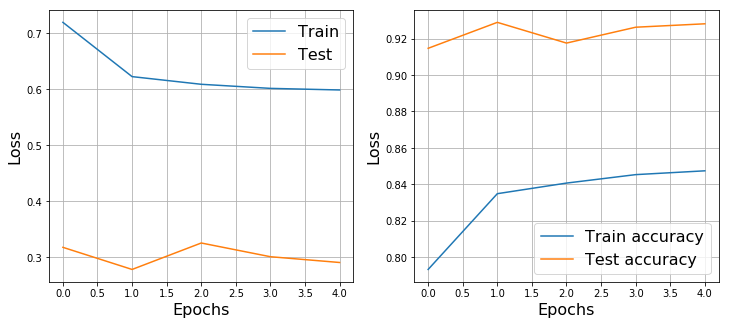

([0.7190490272253561,
  0.6221490208146923,
  0.6084554274834549,
  0.6011585682821172,
  0.5983048582763306],
 [0.31730835649031625,
  0.27782237746670274,
  0.3250470793322672,
  0.3005397146261191,
  0.29023613186576697],
 [0.7932936, 0.8348714, 0.8406905, 0.84532696, 0.8474202],
 [0.91465586, 0.92889637, 0.91752374, 0.92622626, 0.92810524])

In [14]:
train(net, train_loader, test_loader, 5, 0.01, device='cuda')

In [15]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(DropConnect(in_dim, out_dim, p=0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.247/0.148	Accuracy: 0.935/0.957


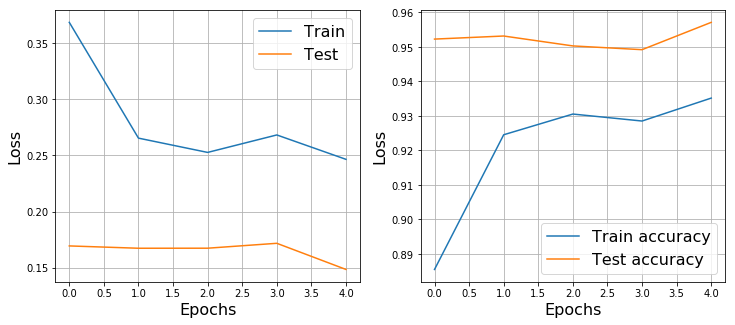

([0.36876694886669165,
  0.2654883035782304,
  0.2527480965404749,
  0.2683275228322569,
  0.24657463818502579],
 [0.16933377134271815,
  0.16726374899661994,
  0.16730233743975434,
  0.17167540281256544,
  0.14835250868072994],
 [0.8855388, 0.92453474, 0.9305315, 0.9285103, 0.9351513],
 [0.952235, 0.953125, 0.9502571, 0.9491693, 0.9570807])

In [16]:
train(net, train_loader, test_loader, 5, 0.01, device='cuda')

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [17]:
class LayerNormalization(nn.Module):
    def __init__(self, num_features, b=0.05, gamma=1.2):
        super().__init__()
        self.b = torch.zeros(num_features) + b
        self.gamma = gamma

    def forward(self, X):
        output = (X - X.mean(1).repeat(X.size()[1], 1).T) / (X.std(1).repeat(X.size()[1], 1).T + 0.01)
        output *= self.gamma
        output += self.b.repeat(X.size()[0]).view(X.size()[0], -1)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [18]:
net = [Flatten()]

sizes = [28 ** 2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.BatchNorm1d(num_features=out_dim))
    net.append(nn.ReLU())
    
net.append(nn.BatchNorm1d(num_features=sizes[-1]))
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.038/0.064	Accuracy: 0.988/0.982


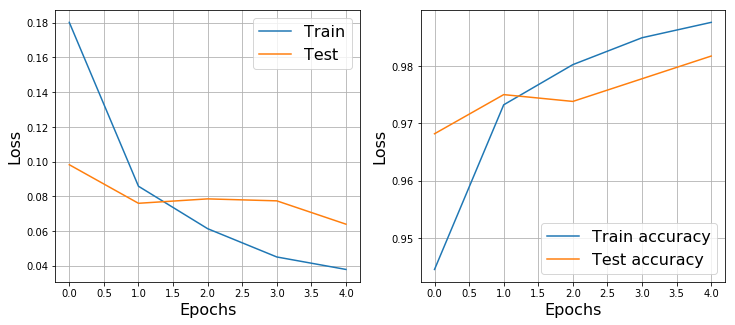

([0.1801425262507218,
  0.08577757497141356,
  0.061337383859145486,
  0.045045360255597244,
  0.037863738409904785],
 [0.09816771392014963,
  0.07595608390490466,
  0.07849827474808391,
  0.07736102029492584,
  0.06392166952166377],
 [0.9445018, 0.9732032, 0.98021054, 0.9848969, 0.9875788],
 [0.96815664, 0.97498024, 0.9737935, 0.9777492, 0.9817049])

In [19]:
train(net, train_loader, test_loader, 5, 0.005, device='cuda')

In [20]:
net = [Flatten()]

sizes = [28 ** 2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(LayerNormalization(num_features=out_dim))
    net.append(nn.ReLU())
    
net.append(LayerNormalization(num_features=sizes[-1]))
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.055/0.078	Accuracy: 0.982/0.976


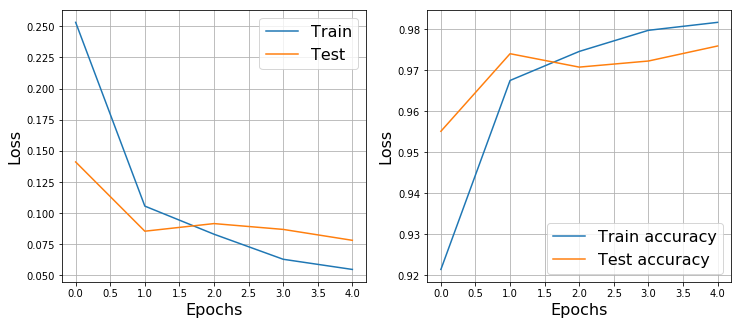

([0.2531531381883474,
  0.10554220191419506,
  0.08297284653009192,
  0.06284157965562619,
  0.05466720884812793],
 [0.1410156171297348,
  0.08538848274870764,
  0.09150468671835865,
  0.08682678359313102,
  0.0780632972505085],
 [0.92145854, 0.96747845, 0.9745469, 0.97968864, 0.98162645],
 [0.95510286, 0.9739913, 0.97072786, 0.97221124, 0.97587025])

In [21]:
train(net, train_loader, test_loader, 5, 0.005, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

Обучение с BatchNorm и LayerNorm проходит лучше, чем обучение с Xavier/He (loss на тесте 0.064/0.078 против 0.290/0.148), при применении этих методов качественно модель получается.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: